## Classic MNIST Classifier using an RBM
Developed by: Jose Pinilla 

In [1]:
# Required Packages
import qaml
import torch

import matplotlib.pyplot as plt

import torchvision.datasets as torch_datasets
import torchvision.transforms as torch_transforms

In [2]:
################################# Hyperparameters ##############################
EPOCHS = 20
BATCH_SIZE = 64
M,N = SHAPE = (28,28)
# Stochastic Gradient Descent
learning_rate = 1e-2
weight_decay = 1e-4
momentum = 0.5

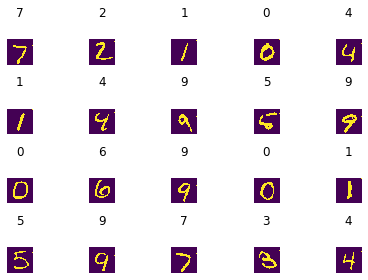

In [3]:
############################ Dataset and Transformations #######################
mnist_train = torch_datasets.MNIST(root='./data/', train=True, download=True,
                                     transform=qaml.datasets.ToBinaryTensor())
                                     # transform=qaml.datasets.ToSpinTensor())
qaml.datasets._embed_labels(mnist_train,axis=1,encoding='one_hot',scale=255)
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE)

mnist_test = torch_datasets.MNIST(root='./data/', train=False, download=True,
                                  transform=qaml.datasets.ToBinaryTensor())
                                  # transform=qaml.datasets.ToSpinTensor())
set_label,get_label = qaml.datasets._embed_labels(mnist_test,encoding='one_hot',
                                                 scale=255,setter_getter=True)
test_loader = torch.utils.data.DataLoader(mnist_test)

# Visualize
fig,axs = plt.subplots(4,5)
for ax,(img,label) in zip(axs.flat,test_loader):
    ax.matshow(img.squeeze())
    ax.set_title(int(label))
    ax.axis('off')
plt.tight_layout()

In [4]:
################################# Model Definition #############################
VISIBLE_SIZE = M*N
HIDDEN_SIZE = 128

# Specify model with dimensions
rbm = qaml.nn.RBM(VISIBLE_SIZE, HIDDEN_SIZE, 'BINARY')

_ = torch.nn.init.uniform_(rbm.b,-0.1,0.1)
_ = torch.nn.init.uniform_(rbm.c,-0.1,0.1)
_ = torch.nn.init.uniform_(rbm.W,-0.1,0.1)

# Set up optimizer
optimizer = torch.optim.SGD(rbm.parameters(), lr=learning_rate,
                                              weight_decay=weight_decay,
                                              momentum=momentum)
# Set up training mechanisms
pos_sampler = neg_sampler = qaml.sampler.GibbsNetworkSampler(rbm,BATCH_SIZE)
CD = qaml.autograd.ContrastiveDivergence

In [5]:
################################## Model Training ##############################
# Set the model to training mode
rbm.train()
err_log = []
accuracy_log = []
for t in range(EPOCHS):
    epoch_error = torch.Tensor([0.])
    for img_batch, labels_batch in train_loader:

        input_data = img_batch.flatten(1)

        # Positive Phase
        v0, p_h0 = pos_sampler(input_data, k=0)
        # Negative Phase
        p_vk, p_hk = neg_sampler(v0, k=5)

        # Reconstruction error from Contrastive Divergence
        err = CD.apply(neg_sampler, (v0,p_h0), (p_vk,p_hk), *rbm.parameters())

        # Do not accumulated gradients
        optimizer.zero_grad()
        # Compute gradients. Save compute graph at last epoch
        err.backward(retain_graph = (t==EPOCHS-1))

        # Update parameters
        optimizer.step()
        epoch_error  += err
    err_log.append(epoch_error.item())
    print(f"Epoch {t} Reconstruction Error = {epoch_error.item()}")

    ############################## CLASSIFICATION ##################################
    count = 0
    for test_data, test_label in test_loader:
        input_data = set_label(test_data.view(1,*SHAPE),0)
        prob_hk = rbm.forward(input_data.flatten(1))
        label_pred = get_label(rbm.generate(prob_hk).view(1,*SHAPE))
        if label_pred.argmax() == test_label.item():
            count+=1
    accuracy_log.append(count/len(mnist_test))
    print(f"Testing accuracy: {count}/{len(mnist_test)}")


Epoch 0 Reconstruction Error = 32289.478515625
Testing accuracy: 8169/10000
Epoch 1 Reconstruction Error = 16888.171875
Testing accuracy: 8667/10000
Epoch 2 Reconstruction Error = 16017.0947265625
Testing accuracy: 8838/10000
Epoch 3 Reconstruction Error = 15483.3271484375
Testing accuracy: 8925/10000
Epoch 4 Reconstruction Error = 15131.169921875
Testing accuracy: 8969/10000
Epoch 5 Reconstruction Error = 14874.3466796875
Testing accuracy: 9014/10000
Epoch 6 Reconstruction Error = 14627.3232421875
Testing accuracy: 9032/10000
Epoch 7 Reconstruction Error = 14446.583984375
Testing accuracy: 9051/10000
Epoch 8 Reconstruction Error = 14272.3408203125
Testing accuracy: 9058/10000
Epoch 9 Reconstruction Error = 14127.5654296875
Testing accuracy: 9066/10000
Epoch 10 Reconstruction Error = 13958.802734375
Testing accuracy: 9080/10000
Epoch 11 Reconstruction Error = 13817.4296875
Testing accuracy: 9063/10000
Epoch 12 Reconstruction Error = 13715.26953125
Testing accuracy: 9065/10000
Epoch 13 

Text(0.5, 0, 'Epoch')

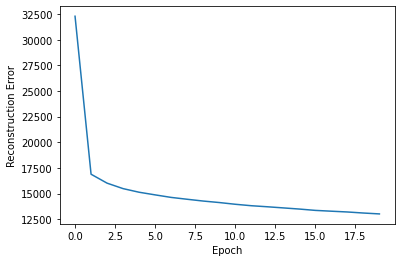

In [6]:
# Reconstruction error graph
fig, ax = plt.subplots()
plt.plot(err_log)
plt.ylabel("Reconstruction Error")
plt.xlabel("Epoch")


Text(0.5, 0, 'Epoch')

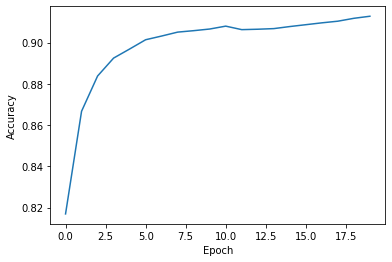

In [7]:
# Accuracy graph
fig, ax = plt.subplots()
plt.plot(accuracy_log)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

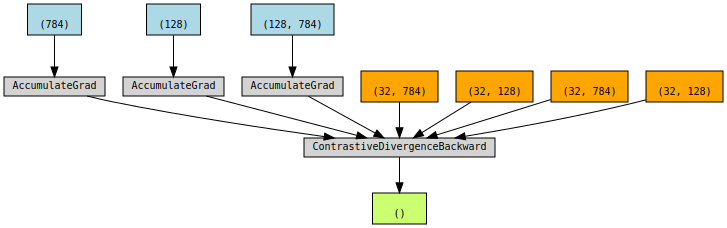

In [8]:
################################# VISUALIZE ####################################
# Computation Graph
from torchviz import make_dot
make_dot(err)

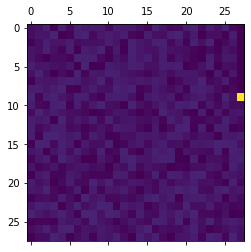

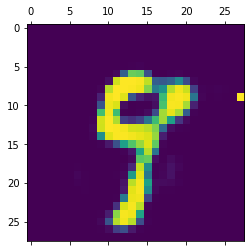

In [15]:
################################# ANIMATION ####################################

from matplotlib.animation import FuncAnimation
label = (torch.nn.functional.one_hot(torch.LongTensor([9]),10))
clamped = set_label(0.1*torch.rand(1,M,N),label)

FRAMES = 200
img_data = [clamped.detach().clone().numpy()]
for i in range(FRAMES):
    prob_hr = rbm.forward(clamped.flatten().bernoulli()).bernoulli()
    prob_vr = rbm.generate(prob_hr).view(1,M,N)
    clamped = set_label(prob_vr,label)
    img_data.append(clamped.detach().clone().numpy())

fig = plt.figure()
plot = plt.matshow(img_data[0].reshape(*SHAPE),fignum=0)

def init():
    plot.set_data(img_data[0].reshape(*SHAPE))
    return [plot]

def update(j):
    plot.set_data(img_data[j].reshape(*SHAPE))
    return [plot]

anim = FuncAnimation(fig,update,init_func=init,frames=FRAMES,interval=10,blit=True)
plt.show(block=False)
anim.save("./animation.gif","pillow")

plt.matshow(img_data[-1].reshape(*SHAPE),fignum=0)